In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from faster_rcnn.utils.datasets.voc.voc import VOCDetection
import numpy as np
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from faster_rcnn.utils.datasets.data_generator import CocoGenerator
from faster_rcnn.utils.datasets.data_generator import Enqueuer
from torch.optim import SGD, RMSprop, Adam

from faster_rcnn.faster_rcnn import FastRCNN, RPN
from pycrayon import CrayonClient
import torch
from torch.optim.lr_scheduler import StepLR
from datetime import datetime
from PIL import Image, ImageDraw, ImageFont


In [3]:
root = '/data/data'
ds = VOCDetection(root, 'train')
print(len(ds))

245


In [4]:
def imshow(inp, gt_boxes=[], predict_boxes = []):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    fig,ax = plt.subplots(1, figsize=(20, 10))

    ax.imshow(inp)
    for i, box in enumerate(gt_boxes):
        print(box)
        rect = patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1]  ,linewidth=2,edgecolor='r',facecolor='none')
        # Add the patch to the Axes
        ax.add_patch(rect)
        
    for i, box in enumerate(predict_boxes):
        rect = patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1]  ,linewidth=1,edgecolor='g',facecolor='none')
        # Add the patch to the Axes
        ax.add_patch(rect)

    plt.pause(0.001)  # pause a bit so that plots are updated


In [5]:
batch_size = 3

In [6]:
data_gen = CocoGenerator(data=ds, batch_size=batch_size, shuffle=True)
queue = Enqueuer(generator=data_gen, use_multiprocessing=False)
queue.start(max_queue_size=20, workers=4)


[217.71428571 224.57142857 282.85714286 277.71428571]


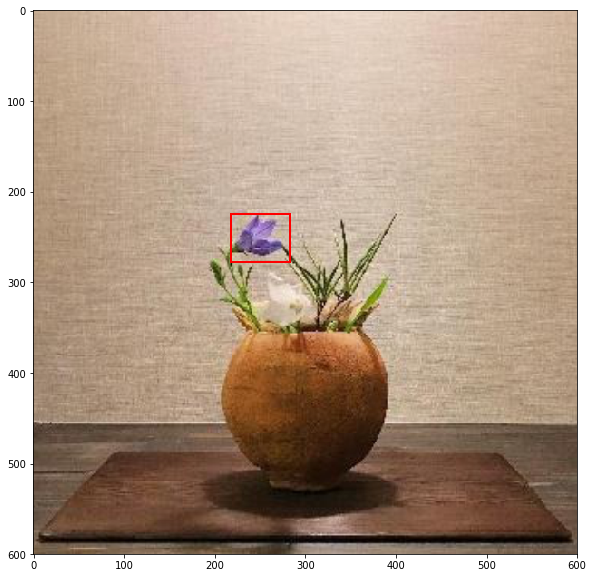

In [7]:
t = queue.get()
blobs = t.next()
gt_boxes = blobs[0]['boxes']
gt_classes = blobs[0]['gt_classes']
imshow(blobs[0]['tensor'][0], gt_boxes)

In [8]:
categories = ds.classes
print(categories)

['__background__', u'276', u'723']


In [9]:
net = FastRCNN(categories, debug=False)
net.cuda()
net.train()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /home/anh/.torch/models/vgg16-397923af.pth
100.0%
/opt/conda/envs/pytorch/lib/python2.7/site-packages/torch/nn/parallel/data_parallel.py:24: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 0 which
    has less than 75% of the memory or cores of GPU 1. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))
faster_rcnn/network.py:26: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  nn.init.xavier_normal(self.conv.weight)
faster_rcnn/network.py:54: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  nn.init.xavier_normal(self.fc.weight)


FastRCNN(
  (rpn): RPN(
    (features): DataParallel(
      (module): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace)
        (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU(inplace)
        (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (6): ReLU(inplace)
        (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (8): ReLU(inplace)
        (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (11): ReLU(inplace)
        (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (13): ReLU(inplace)
        (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (15): 

In [12]:
params = filter(lambda x: x.requires_grad, net.parameters())
optimizer = SGD(params, lr=1e-4, momentum=0.9, weight_decay=0.0005)
exp_lr_scheduler = StepLR(optimizer, step_size=100, gamma=0.8)

In [37]:
def train(data_gen, optimizer, lr_scheduler ,model, epochs, steps_per_epoch):
    
    exp_name = datetime.now().strftime('vgg16_%m-%d_%H-%M-%s')
    cc = CrayonClient(hostname="crayon", port=8889)
    exp = cc.create_experiment(exp_name)
    
    model.train()
    train_loss = 0
    cross_entropy = 0
    loss_box = 0
    rpn_loss = 0
    for epoch in range(epochs):
        
        for step in range(1, steps_per_epoch +1):
            lr_scheduler.step()        
            blobs = data_gen.next()
            current_batch_size = len(blobs)
            max_height = np.max([blob['tensor'].shape[2] for blob in blobs])
            max_width = np.max([blob['tensor'].shape[3] for blob in blobs])
            batch_tensor = torch.Tensor(current_batch_size, 3, max_height, max_width).fill_(0.)
            total_boxes = 0
            batch_boxes = np.empty((0, 5))
            batch_boxes_index = np.empty((0,), dtype=np.int)
            im_info = np.array([[batch_tensor.shape[2], batch_tensor.shape[3]]])
            for i, blob in enumerate(blobs):
                shape = blob['tensor'].shape
                batch_tensor[i,:, :shape[2], :shape[3] ] = blob['tensor']
                total_boxes = blob['boxes'].shape[0]
                gt_classes =  blob['gt_classes']
                gt_boxes = np.hstack([blob['boxes'] , gt_classes[:, np.newaxis]])
                batch_boxes = np.vstack((batch_boxes, gt_boxes))
                a =  np.zeros((total_boxes , ), dtype=np.int)
                a.fill(i)
                batch_boxes_index = np.concatenate((batch_boxes_index, a), axis=0)

            cls_prob, bbox_pred, rois = model(batch_tensor, im_info, batch_boxes, batch_boxes_index)



            cls_data = cls_prob.data.cpu().numpy()
            max_class_idx = np.argmax(cls_data, axis=1)
            loss = model.loss
            cross_entropy += model.cross_entropy.item()
            loss_box += model.loss_box.item()
            train_loss += loss.item()
            rpn_loss += model.rpn.loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            current_step = epoch * steps_per_epoch + step
            if step % 10 == 0:
                log_text = 'epoch: %d : step %d,  loss: %.4f' % (
                    epoch + 1, step , train_loss /current_step)
                print(log_text)

                re_cnt = True
            if step % 10 == 0:
                exp.add_scalar_value('train_loss', train_loss / current_step, step=current_step)
                exp.add_scalar_value('rpn_loss', rpn_loss /  current_step, step=current_step)
                exp.add_scalar_value('cross_entropy', cross_entropy / current_step, step=current_step)
                exp.add_scalar_value('loss_box', loss_box /  current_step, step=current_step)


            if step % 100 == 0:
                torch.save(model.state_dict(), 'faster_model_at_step_%s.pkl' % step)


In [36]:
train(t, optimizer=optimizer,lr_scheduler=exp_lr_scheduler, model=net, epochs=1, steps_per_epoch=150)

epoch: 0 : step 10,  loss: 1.2269
epoch: 0 : step 20,  loss: 1.2489
epoch: 0 : step 30,  loss: 1.2008
epoch: 0 : step 40,  loss: 1.1905
epoch: 0 : step 50,  loss: 1.1937
epoch: 0 : step 60,  loss: 1.1911
epoch: 0 : step 70,  loss: 1.1760
epoch: 0 : step 80,  loss: 1.1792
epoch: 0 : step 90,  loss: 1.1668
epoch: 0 : step 100,  loss: 1.1679
epoch: 0 : step 110,  loss: 1.1648
epoch: 0 : step 120,  loss: 1.1698
epoch: 0 : step 130,  loss: 1.1572
epoch: 0 : step 140,  loss: 1.1618
epoch: 0 : step 150,  loss: 1.1551


[{'boxes': array([[ 49.71428571, 265.71428571, 531.42857143, 600.        ],
         [ 78.85714286,  73.71428571, 440.57142857, 238.28571429]]),
  'gt_classes': array([2, 2], dtype=int32),
  'im_info': array([[600.        , 600.        ,   1.71428571]]),
  'im_name': '1500206880470_thum_1500206880012_thum_photo.jpg',
  'tensor': tensor([[[[-1.4329, -1.4329, -1.4500,  ..., -1.2788, -1.2617, -1.2617],
            [-1.4329, -1.4329, -1.4500,  ..., -1.2788, -1.2617, -1.2617],
            [-1.4329, -1.4329, -1.4500,  ..., -1.2959, -1.2788, -1.2617],
            ...,
            [-1.7583, -1.7583, -1.7583,  ..., -1.7412, -1.7240, -1.7240],
            [-1.7583, -1.7583, -1.7583,  ..., -1.7583, -1.7412, -1.7412],
            [-1.7583, -1.7583, -1.7583,  ..., -1.7583, -1.7412, -1.7412]],
  
           [[-1.1078, -1.1078, -1.1253,  ..., -0.8978, -0.8803, -0.8803],
            [-1.1078, -1.1078, -1.1253,  ..., -0.8978, -0.8803, -0.8803],
            [-1.1078, -1.1078, -1.1253,  ..., -0.9153, -0.

In [39]:
net.load_state_dict(torch.load('faster_model_at_step_500.pkl'))

In [40]:
def result_show(inp, predicted_boxes=[], classes=[], scores=[]):
    font = ImageFont.truetype(font ='./font/FiraMono-Medium.otf', size=np.floor(3e-2 * 600 + 0.5).astype('int32'))
    
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    
    inp *= 255.0/inp.max() 
    
    fig,ax = plt.subplots(1, figsize=(20, 10))
    
    image = Image.fromarray(inp.astype('uint8'))
    
    draw = ImageDraw.Draw(image)
    for predicted_box, predicted_class, score in zip(predicted_boxes, classes, scores):
        label = '{} {:.2f}'.format(predicted_class, score)

        
        label_size = draw.textsize(label, font)
        
        left, top, right, bottom = predicted_box
        print(predicted_class, (left, top), (right, bottom))
        
        for i in range(3):
            draw.rectangle(
                [left + i, top + i, right - i, bottom - i],
                outline=(255,255,0))
        if top - label_size[1] >= 0:
            text_origin = np.array([left, top - label_size[1]])
        else:
            text_origin = np.array([left, top + 1])
        draw.rectangle(
                [tuple(text_origin), tuple(text_origin + label_size)])
        draw.text(text_origin, label, fill=(100, 100, 255), font=font)
    del draw
    ax.imshow(image)

(u'723', (124.43706560831691, 73.68212142017234), (686.8598181470124, 484.1770283747041))


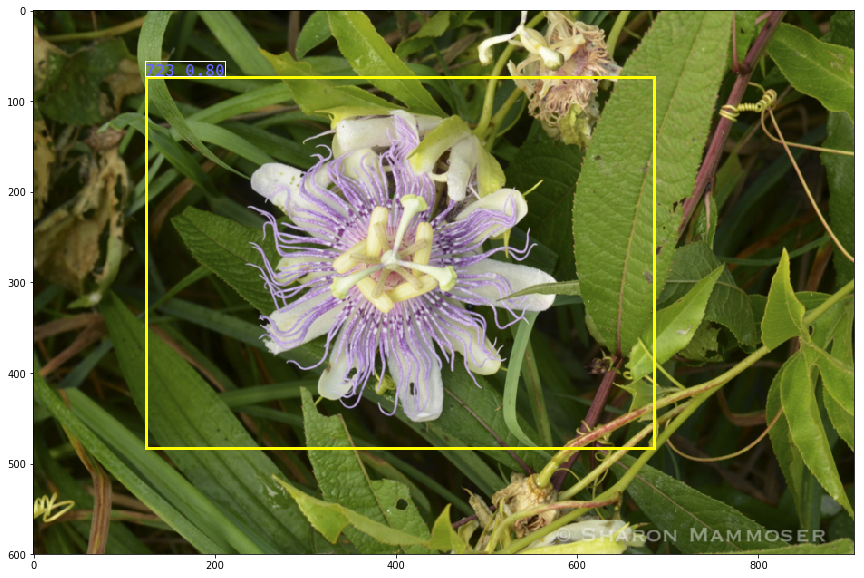

In [42]:
pred_boxes, scores, classes, rois, blob = net.detect('./test_im/test5.jpg', thr=0.8)
result_show(blob[0], pred_boxes,classes, scores)